### Machine Learning model (using PyTorch) to predict the number of ellipses in the image while ignoring the polygons. The approach used is to cast the problem as a classification with the six classes corresponding to 0, 1, 2, 3, 4, 5 ellipses present in an image.

## Importing libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os 
from PIL import Image
from torch.autograd import Variable
import sys


## Checking the directory
Displaying the directory where the dataset files are present.

In [2]:
print(os.listdir())
data_dir = 'shapes_dataset_HR'
print(data_dir)
data_dir = os.path.join(os.getcwd(), data_dir)
print(data_dir)

['.ipynb_checkpoints', 'Aston_MachineLearning_assessment.pdf', 'checkpoint.pth', 'object_detection_aston_test_1.py', 'object_detection_aston_train_1.py', 'object_detection_pytorch_aston_1.ipynb', 'object_detection_pytorch_aston_1.py', 'shapes_dataset_HR', 'shapes_dataset_HR.zip', 'shapes_dataset_LR.zip', 'shapes_dataset_MR.zip']
shapes_dataset_HR
C:\Users\sunny\Google Drive\aston\shapes_dataset_HR


## Splitting the full dataset in training, validation & test datasets
Here, Dataloader class from PyTorch is used to make datasets in the format compatible with PyTorch. Also, main dataset is randomly shuffled/splitted into train, validation and test datasets. This fraction can depend upon the user, given here by variables ```valid_size``` and ```test_size```.

In [3]:
def load_split_train_valid_test(datadir, validsize = 0.2, testsize = 0.1):
    train_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), ])
    valid_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), ])
    test_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), ])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    valid_data = datasets.ImageFolder(datadir, transform=valid_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    num_train = len(train_data)
    num_valid = len(valid_data)
    num_test = len(test_data)
    print('no. of train datapoints: ', num_train)
#     print('no. of valid datapoints:  ', num_valid)
#     print('no. of test datapoints:  ', num_test)
    indices = list(range(num_train))
    split_valid = int(np.floor(validsize * num_train))
    split_test = int(np.floor(testsize * num_train))
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, valid_idx, test_idx = indices[split_test+split_valid:], indices[split_test:split_valid], indices[:split_test]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    validloader = torch.utils.data.DataLoader(valid_data, sampler=valid_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, validloader, testloader


valid_size = 0.2
test_size = 0.1
trainloader, validloader, testloader = load_split_train_valid_test(data_dir, valid_size, test_size)
print(trainloader.dataset.classes)
print(testloader.dataset.classes)
print(len(trainloader), len(validloader), len(testloader))

no. of train datapoints:  10000
['0', '1', '2', '3', '4', '5']
['0', '1', '2', '3', '4', '5']
110 16 16


## Check if GPU is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Pretrained models
Few commonly used models are mentioned below in the code. The model to be used can be uncommented. More details about the models can be found at https://pytorch.org/docs/stable/torchvision/models.html. The parameters/weights of the layers of the pretrained models are not allowed to be changed here by using   ```param.requires_grad = False```

Fully connected layers are added at the last dpeding upon the number of output classes to be predicted, which is 6 in this problem.

Negative log likelihood loss (```nn.NLLLoss()```), learning rate of 0.0005 (```lr=0.0005```), and Adam optimizer (```optim.Adam(model.fc.parameters(), lr=0.0005)```) are used as the hyperparameters. 

In [5]:
model = models.resnet18(pretrained=True)
# model = models.alexnet(pretrained=True)
# model = models.squeezenet1_0(pretrained=True)
# model = models.vgg16(pretrained=True)
# model = models.densenet161(pretrained=True)
# model = models.inception_v3(pretrained=True)
# model = models.resnet50(pretrained=True)
# print(model)
# sys.exit()


for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Dropout(0.2),
                                nn.Linear(256, 6),
                                nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0005)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Train the model
Number of epochs can be decided by the used depending upon when the loss has obained a lower stable value.

Backpropagation phenomenon is implemented here to calculate the loss and accuracy.

In [6]:
def train_the_model():
    epochs = 15
    steps = 0
    running_loss = 0
    print_every = 10
    train_losses, valid_losses = [], []
    for epoch in range(epochs):
        print()
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                valid_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)
                        valid_loss += batch_loss.item()
                        
                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                # train_losses.append(running_loss/len(trainloader))
                train_losses.append(running_loss/print_every)
                valid_losses.append(valid_loss/len(validloader))
                print('Epoch: {}/{}, Train_loss: {:.3f}, Valid_loss: {:.3f}, Valid_accuracy: {:.3f}'.format(epoch+1, epochs, running_loss/print_every, valid_loss/len(validloader), accuracy/len(validloader)))
                running_loss = 0
                model.train()
            

    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    

## Run & save the model
This block can be commented if you don't want to retrain the model. Already saved model (if available) can be used. 


Epoch: 1/15, Train_loss: 1.701, Valid_loss: 1.732, Valid_accuracy: 0.320
Epoch: 1/15, Train_loss: 1.540, Valid_loss: 1.522, Valid_accuracy: 0.421
Epoch: 1/15, Train_loss: 1.383, Valid_loss: 1.387, Valid_accuracy: 0.438
Epoch: 1/15, Train_loss: 1.272, Valid_loss: 1.279, Valid_accuracy: 0.396
Epoch: 1/15, Train_loss: 1.224, Valid_loss: 1.171, Valid_accuracy: 0.533
Epoch: 1/15, Train_loss: 1.184, Valid_loss: 1.141, Valid_accuracy: 0.485
Epoch: 1/15, Train_loss: 1.143, Valid_loss: 1.088, Valid_accuracy: 0.545
Epoch: 1/15, Train_loss: 1.135, Valid_loss: 1.058, Valid_accuracy: 0.562
Epoch: 1/15, Train_loss: 1.052, Valid_loss: 1.019, Valid_accuracy: 0.574
Epoch: 1/15, Train_loss: 1.036, Valid_loss: 0.994, Valid_accuracy: 0.587
Epoch: 1/15, Train_loss: 1.029, Valid_loss: 0.964, Valid_accuracy: 0.598

Epoch: 2/15, Train_loss: 1.001, Valid_loss: 0.984, Valid_accuracy: 0.584
Epoch: 2/15, Train_loss: 1.021, Valid_loss: 0.954, Valid_accuracy: 0.598
Epoch: 2/15, Train_loss: 0.962, Valid_loss: 0.936

Epoch: 11/15, Train_loss: 0.707, Valid_loss: 0.684, Valid_accuracy: 0.699
Epoch: 11/15, Train_loss: 0.663, Valid_loss: 0.685, Valid_accuracy: 0.697
Epoch: 11/15, Train_loss: 0.671, Valid_loss: 0.684, Valid_accuracy: 0.691
Epoch: 11/15, Train_loss: 0.730, Valid_loss: 0.699, Valid_accuracy: 0.675
Epoch: 11/15, Train_loss: 0.724, Valid_loss: 0.682, Valid_accuracy: 0.706
Epoch: 11/15, Train_loss: 0.707, Valid_loss: 0.687, Valid_accuracy: 0.698
Epoch: 11/15, Train_loss: 0.687, Valid_loss: 0.679, Valid_accuracy: 0.701
Epoch: 11/15, Train_loss: 0.790, Valid_loss: 0.743, Valid_accuracy: 0.667
Epoch: 11/15, Train_loss: 0.699, Valid_loss: 0.718, Valid_accuracy: 0.687
Epoch: 11/15, Train_loss: 0.677, Valid_loss: 0.679, Valid_accuracy: 0.699

Epoch: 12/15, Train_loss: 0.659, Valid_loss: 0.684, Valid_accuracy: 0.698
Epoch: 12/15, Train_loss: 0.758, Valid_loss: 0.708, Valid_accuracy: 0.685
Epoch: 12/15, Train_loss: 0.757, Valid_loss: 0.702, Valid_accuracy: 0.685
Epoch: 12/15, Train_loss: 0.713, Vali

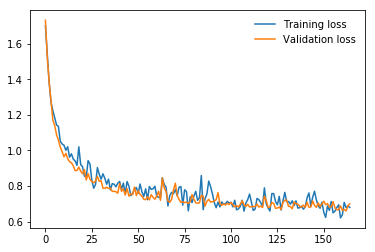

In [7]:
train_the_model()
torch.save(model, 'checkpoint.pth')

## Load the saved model

In [8]:
model = torch.load('checkpoint.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

## Predicting on test images
Here some random images have been taken from the test dataset and prediction about how many ellipses are present in each image is implemented.

Number of ellipses (actual and predicted) are mentioned at the top of each subplot test image (chosen randomly). 


64 tensor([1, 0, 5, 3, 3, 5, 3, 3, 2, 2, 4, 5, 0, 3, 2, 1, 1, 1, 0, 2, 0, 3, 3, 4,
        4, 5, 0, 2, 1, 3, 0, 0, 5, 5, 0, 5, 0, 3, 5, 5, 5, 2, 1, 5, 2, 2, 4, 4,
        5, 3, 0, 2, 2, 2, 3, 0, 3, 4, 5, 1, 4, 1, 3, 3])


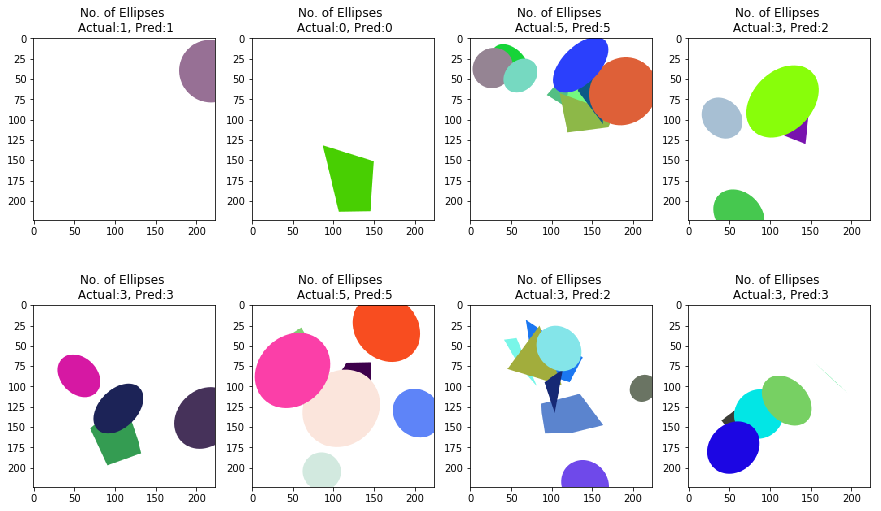

In [10]:
def predict_image(image):
    test_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), ])
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_test_images(loader):
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels  


to_pil = transforms.ToPILImage()
images, labels = get_test_images(testloader)
print()
print(len(images), labels)
fig=plt.figure(figsize=(15,9))    
for ii in range(8):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(2, 4, ii+1)
    res = int(labels[ii]) == index
    # sub.set_title(str(index) + ":" + str(res))
    sub.set_title("No. of Ellipses \n Actual:" + str(int(labels[ii])) + ", Pred:" + str(index))
    # plt.axis('off')
    plt.imshow(image)
plt.show()